In [1]:
import os
import sys 
from flask import Flask
from flask import request
from flask_api import status
import psycopg2
import json
import copy
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))
datosBaseDeDatos = {"usuario":"postgres","password":"carlos98","Host":"127.0.0.1","puerto":"5432","DB":"chatblocks"}

In [2]:
def abrirJson(name,path=os.getcwd()+"/" ):
    with open(path+name,encoding='utf-8') as data_file:  
        diccionario = json.load(data_file)
    return diccionario

In [3]:
def conexionBaseDeDatos(datosConexion):
    try:
        connection = psycopg2.connect(user = datosConexion["usuario"],
                              password = datosConexion["password"],
                              host = datosConexion["Host"],
                              port = datosConexion["puerto"],
                              database = datosConexion["DB"])    
        return connection
    except(Exception, psycopg2.Error) as error:
        print("Error al conectar con base de datos", error)

In [4]:
def consultar(connection,datos=False,consulta=False,tabla=False):
    #print("datos",datos)
    consultaBots = list()
    column_names = []
    data_rows = []
    diccionarioDatos = dict()
    consultas = list()
    cursor = connection.cursor()  
    cosulta =""    
    if datos:
        print("intenatando consulta...")
        if tabla == 'robots':
            consulta = "select * from robots where id_face = '"+datos["id_face"]+"';"
        else:
            consulta = "select * from "+tabla+" where "        
            i=0
            for dato, valorDato in datos.items():
                if i==0:
                    consulta = consulta+dato+"= '"+str(valorDato)+"'"                
                else:             
                    consulta = consulta+" and "+dato+"= '"+str(valorDato)+"'" 
                i=i+1
            #print(dato,":",valorDato)
            consulta= consulta + " ;" 
            #print(consulta)        
            #consulta = "select * from robots where name_robot = '"+datosBot["name_robot"]+"' and id_face = '"+ datosBot["id_face"]+"' and  type_blocki = '"+datosBot["type_blocki"]+"' and access_token= '"+datosBot["access_token"]+"' and id_user = '"+datosBot["id_user"]+"';"
    print("consulta:",consulta)
    cursor.execute(consulta)    
    column_names = [desc[0] for desc in cursor.description]  
    rows = cursor.fetchall()
    for row in rows:
        diccionarioDatos = dict()
        for i in range(len(column_names)):
            diccionarioDatos.update({column_names[i]:row[i]})
        consultaBots.append(diccionarioDatos)
    cursor.close()
    connection.close()  
    
    if len(consultaBots)==1:
        return consultaBots[0]
    elif len(consultaBots)==0:
        print('La consulta no trajo nada')
        return {"error": "true"}
    else:
        return consultaBots

In [5]:
def insert(datos,tabla,connection):
    cursor = connection.cursor()
    values = ""
    datosInsert = ""
    i = 0;
    for dato, valorDato in datos.items():
        if i==0:
            values = values+dato 
            datosInsert = datosInsert+"'"+str(valorDato)+"' "                
        else:
            values = values+","+dato
            datosInsert =datosInsert+",'"+str(valorDato)+"' "
        i=i+1
    insersion  = "insert into "+tabla+" ( "+values+" ) values ("+datosInsert+" );" 
    cursor.execute(insersion)
    connection.commit()
    cursor.close()
    connection.close()
    return datos

In [6]:
def update(datosActualizar,datos,tabla,connection):
    actualizar =" "
    actualizar = "update "+tabla+" set"
    j = 0
    for dato,informacionDato in datosActualizar.items():
        print(dato)
        if j==0:
            actualizar=actualizar+" "+dato+"="+str(informacionDato)
            j=j+1
        else:
             actualizar=actualizar+", "+dato+"="+str(informacionDato)
    
    i=0
    actualizar=actualizar+" where "
    for dato, valorDato in datos.items():
        if i==0:
            actualizar = actualizar+dato+"= '"+str(valorDato)+"'"                
        else:             
            actualizar = actualizar+" and "+dato+"= '"+str(valorDato)+"'" 
        i=i+1
    actualizar= actualizar + " ;"  

In [7]:
app = Flask(__name__)
@app.route('/access_token', methods = ['POST'])
def postAccessToken():
    try:         
        connection = conexionBaseDeDatos(datosBaseDeDatos)        
        datosVariable = request.get_json()   
        tabla = "robots"
        con = consultaBots(connection,datos=datosVariable,tabla=tabla)        
        listaAcessToken=list()
        if type(con)==list:
            for i in range(len(con)):
                print(con[i])
                listaAcessToken.append(con[i]["access_token"])
        else:
            listaAcessToken.append(con["access_token"])         
        print(listaAcessToken)
        return {"access_token":listaAcessToken}
    except:
        return datosVariable,status.HTTP_404_NOT_FOUND


In [8]:
@app.route('/insert/<tabla>',methods=['POST'])
def funcionalidad(tabla):
    try:
        connection = conexionBaseDeDatos(datosBaseDeDatos)
        datos = request.get_json()
        print("Datos recibidos:")
        print(datos)
        insert(datos,str(tabla),connection)
        connection = conexionBaseDeDatos(datosBaseDeDatos)
        consulta = consultar(connection,datos=datos,tabla=str(tabla))
        print("Datos enviados:")
        print (consulta)
        return consulta
    except (Exception, psycopg2.Error) as error :
        print("error",error)
        return tabla,status.HTTP_404_NOT_FOUND

In [9]:
@app.route('/select/<tabla>',methods=['GET'])
def select(tabla):
    try:
        connection = conexionBaseDeDatos(datosBaseDeDatos)
        datos = request.get_json()
        print("Datos recibidos:")
        print(datos)
        
        consulta = consultar(connection,datos=datos,tabla=str(tabla))
        print("Datos enviados:")
        print (consulta)
        return consulta
    except (Exception, psycopg2.Error) as error :
        print("error",error)
        return tabla,status.HTTP_404_NOT_FOUND

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://localhost:8181/ (Press CTRL+C to quit)
127.0.0.1 - - [18/Mar/2021 20:01:13] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:01:13] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:01:13] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select 

127.0.0.1 - - [18/Mar/2021 20:01:13] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:01:13] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'contenttype': 'text', 'typingtime': 7, 'id_robot': 407, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '407' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1220, 'id_robot': 407, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 407, 'blockty

127.0.0.1 - - [18/Mar/2021 20:01:13] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:01:13] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:01:13] "POST /insert/variables HTTP/1.1" 200 -


Datos enviados:
{'id_var': 963, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 407, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 407, 'id_var': 963, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '407' and id_var= '963' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '963', 'id_block':

127.0.0.1 - - [18/Mar/2021 20:01:13] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:01:13] "POST /insert/elementos HTTP/1.1" 200 -


Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 964, 'id_robot': 407}
intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '964' and id_robot= '407' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '964', 'id_block': 189, 'id_robot': 407, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 189}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://st2.depositphoto

127.0.0.1 - - [18/Mar/2021 20:01:13] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:01:14] "POST /insert/botones HTTP/1.1" 200 -


Datos enviados:
{'id_elemento': '428', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 668, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '428', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'opc_nextid': 'https://www.reddit.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '428' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '428', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 669, 'opc_nextid': 'https://www.reddit.com/'}


127.0.0.1 - - [18/Mar/2021 20:11:02] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:11:03] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:11:03] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select 

127.0.0.1 - - [18/Mar/2021 20:11:03] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:11:03] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:11:03] "POST /insert/variables HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '408' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1223, 'id_robot': 408, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 408, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'Salida' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and 

127.0.0.1 - - [18/Mar/2021 20:11:03] "POST /insert/bloquequickreply HTTP/1.1" 200 -


Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 408, 'id_var': 965, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '408' and id_var= '965' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '965', 'id_block': 428, 'id_robot': 408, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_slide

127.0.0.1 - - [18/Mar/2021 20:11:03] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:11:03] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:11:03] "POST /insert/elementos HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '408' ;
Datos enviados:
{'id_var': 966, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 408, 'name_var': 'var_slideMenu'}
Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 966, 'id_robot': 408}
intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '966' and id_robot= '408' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '966', 'id_block': 190, 'id_robot': 408, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://st2.

127.0.0.1 - - [18/Mar/2021 20:11:03] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:11:03] "POST /insert/botones HTTP/1.1" 200 -


Datos recibidos:
{'id_elemento': '429', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'opc_nextid': 'https://www.youtube.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '429' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '429', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 670, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '429', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'opc_nextid': 'https://www.reddit.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '429' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Dato

127.0.0.1 - - [18/Mar/2021 20:14:32] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:14:32] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:14:32] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select 

127.0.0.1 - - [18/Mar/2021 20:14:32] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:14:32] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'contenttype': 'text', 'typingtime': 7, 'id_robot': 409, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '409' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1226, 'id_robot': 409, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 409, 'blockty

127.0.0.1 - - [18/Mar/2021 20:14:32] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:14:32] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:14:32] "POST /insert/variables HTTP/1.1" 200 -


Datos enviados:
{'id_var': 967, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 409, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 409, 'id_var': 967, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '409' and id_var= '967' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '967', 'id_block':

127.0.0.1 - - [18/Mar/2021 20:14:32] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:14:33] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:14:33] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '968' and id_robot= '409' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '968', 'id_block': 191, 'id_robot': 409, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 191}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg' and subtitle= 'Esta es una prueba de carrusel.' and blockt

127.0.0.1 - - [18/Mar/2021 20:14:33] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from botones where id_elemento= '430' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '430', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 673, 'opc_nextid': 'https://www.reddit.com/'}


127.0.0.1 - - [18/Mar/2021 20:19:15] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:19:15] "POST /insert/robots HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select 

127.0.0.1 - - [18/Mar/2021 20:19:15] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:19:16] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:19:16] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos enviados:
{'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1228, 'id_robot': 410, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'contenttype': 'text', 'typingtime': 7, 'id_robot': 410, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '410' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'conten

127.0.0.1 - - [18/Mar/2021 20:19:16] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:19:16] "POST /insert/bloquequickreply HTTP/1.1" 200 -


Datos recibidos:
{'name_var': 'var_case', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 410}
intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '410' ;
Datos enviados:
{'id_var': 969, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 410, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 410, 'id_var': 969, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '410' and id_var= '969' and bloc

127.0.0.1 - - [18/Mar/2021 20:19:16] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:19:16] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:19:16] "POST /insert/elementos HTTP/1.1" 200 -


Datos enviados:
{'id_var': 970, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 410, 'name_var': 'var_slideMenu'}
Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 970, 'id_robot': 410}
intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '970' and id_robot= '410' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '970', 'id_block': 192, 'id_robot': 410, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_bl

127.0.0.1 - - [18/Mar/2021 20:19:16] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:19:16] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from botones where id_elemento= '431' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '431', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 674, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '431', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'opc_nextid': 'https://www.reddit.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '431' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '431', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 675, 'opc_nextid': 'https://www.redd

127.0.0.1 - - [18/Mar/2021 20:20:36] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:20:36] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:20:36] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...


127.0.0.1 - - [18/Mar/2021 20:20:36] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:20:36] "POST /insert/bloqueinput HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:20:36] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'email' and opc_type= 'Variable' and var= '0' and opc_data= 'String' and id_robot= '411' ;
Datos enviados:
{'id_var': 971, 'opc_type': 'Variable', 'opc_data': 'String', 'var': '0', 'id_robot': 411, 'name_var': 'email'}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'default_id': 'prueba_captura', 'namestate': 'prueba_captura', 'contenido': 'introduce tu correo', 'contenttype': 'text', 'typingtime': 3, 'validacion': '^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$', 'id_robot': 411, 'id_var': 971, 'blocktype': 'input'}
intenatando consulta...
consulta: select * from bloqueinput where next_id= 'pruebaCorreo_01inicial_inicial' and default_id= 'prueba_captura' and namestate= 'prueba_captura' and contenido= 'introduce tu correo' and contenttype= 'text' and typingtime= '3' and validacion= '^[a-z0-9]+[\._]?[a-z0-9]+[@]\w+[.]\w{2,3}$' and id_robot= '411' and id_var= '971' and blocktype= 'input' ;
Datos envi

127.0.0.1 - - [18/Mar/2021 20:20:36] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:20:36] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:20:36] "POST /insert/bloquequickreply HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'Salida' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and contenttype= 'text' and typingtime= '3' and id_robot= '411' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'next_id': 'Salida', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1233, 'id_robot': 411, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_case', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 411}
intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '411' ;
Datos enviados:
{'id_var': 972, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 411, 'name_

127.0.0.1 - - [18/Mar/2021 20:20:36] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:20:37] "POST /insert/bloqueslide HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '411' ;
Datos enviados:
{'id_var': 973, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 411, 'name_var': 'var_slideMenu'}
Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 973, 'id_robot': 411}
intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '973' and id_robot= '411' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '973', 'id_block': 193, 'id_robot': 411, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': '', 'subtitle
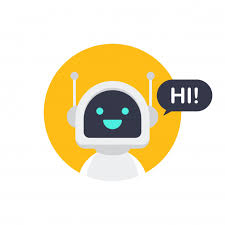
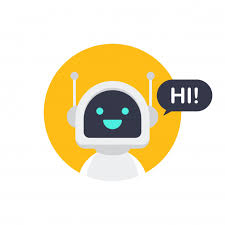

127.0.0.1 - - [18/Mar/2021 20:20:37] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:20:37] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:20:37] "POST /insert/botones HTTP/1.1" 200 -


Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': '', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 193, 'id_elements': 432}
Datos recibidos:
{'id_elemento': '432', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'opc_nextid': 'https://www.youtube.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '432' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '432', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 676, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '432', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'opc_nextid': 'https://www.reddit.com/'}
intenatando consulta...
consulta: select * from botones where
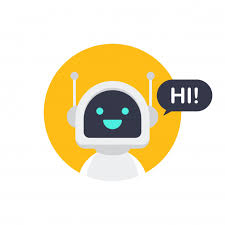

127.0.0.1 - - [18/Mar/2021 20:36:46] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:36:46] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:36:47] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...


127.0.0.1 - - [18/Mar/2021 20:36:47] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:36:47] "POST /insert/bloqueinput HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'email' and opc_type= 'Variable' and var= '0' and opc_data= 'String' and id_robot= '412' ;
Datos enviados:
{'id_var': 974, 'opc_type': 'Variable', 'opc_data': 'String', 'var': '0', 'id_robot': 412, 'name_var': 'email'}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'default_id': 'prueba_captura', 'namestate': 'prueba_captura', 'contenido': 'introduce tu correo', 'contenttype': 'text', 'typingtime': 3, 'validacion': '^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$', 'id_robot': 412, 'id_var': 974, 'blocktype': 'input'}
intenatando consulta...
consulta: select * from bloqueinput where next_id= 'pruebaCorreo_01inicial_inicial' and default_id= 'prueba_captura' and namestate= 'prueba_captura' and contenido= 'introduce tu correo' and contenttype= 'text' and typingtime= '3' and validacion= '^[a-z0-9]+[\._]?[a-z0-9]+[@]\w+[.]\w{2,3}$' and id_robot= '412' and id_var= '974' and blocktype= 'input' ;
Datos envi

127.0.0.1 - - [18/Mar/2021 20:36:47] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:36:47] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:36:47] "POST /insert/variables HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '412' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1235, 'id_robot': 412, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 412, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'Salida' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and 

127.0.0.1 - - [18/Mar/2021 20:36:47] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:36:47] "POST /insert/variables HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '412' and id_var= '975' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '975', 'id_block': 432, 'id_robot': 412, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_slideMenu', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 412}
intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '412' ;
Datos envia

127.0.0.1 - - [18/Mar/2021 20:36:47] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:36:47] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:36:47] "POST /insert/botones HTTP/1.1" 200 -


Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '976', 'id_block': 194, 'id_robot': 412, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': '', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 194}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= '' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '194' ;
Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': '', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 194, 'id_elements': 433}
Datos recibidos:
{'id_elemento': '433', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'opc_nextid': 'https://www.youtube.com/'}
intenatando consulta...
consulta: select *
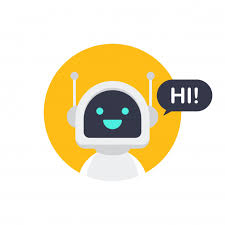
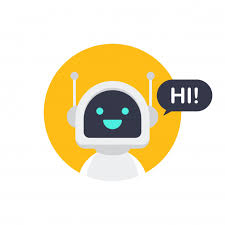
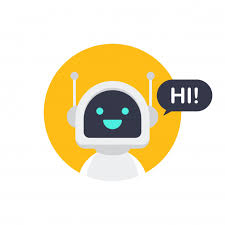

127.0.0.1 - - [18/Mar/2021 20:36:48] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from botones where id_elemento= '433' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '433', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 679, 'opc_nextid': 'https://www.reddit.com/'}


127.0.0.1 - - [18/Mar/2021 20:36:55] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:36:55] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:36:55] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select 

127.0.0.1 - - [18/Mar/2021 20:36:55] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:36:55] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:36:55] "POST /insert/variables HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '413' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1238, 'id_robot': 413, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 413, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'Salida' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and 

127.0.0.1 - - [18/Mar/2021 20:36:55] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:36:55] "POST /insert/variables HTTP/1.1" 200 -


Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 413, 'id_var': 977, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '413' and id_var= '977' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '977', 'id_block': 433, 'id_robot': 413, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_slide

127.0.0.1 - - [18/Mar/2021 20:36:55] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:36:55] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:36:56] "POST /insert/botones HTTP/1.1" 200 -


Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '978', 'id_block': 195, 'id_robot': 413, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 195}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '195' ;
Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal

127.0.0.1 - - [18/Mar/2021 20:36:56] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from botones where id_elemento= '434' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '434', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 681, 'opc_nextid': 'https://www.reddit.com/'}


127.0.0.1 - - [18/Mar/2021 20:39:21] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:39:21] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:39:21] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select 

127.0.0.1 - - [18/Mar/2021 20:39:21] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:39:21] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'contenttype': 'text', 'typingtime': 7, 'id_robot': 414, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '414' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1241, 'id_robot': 414, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 414, 'blockty

127.0.0.1 - - [18/Mar/2021 20:39:21] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:39:21] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:39:21] "POST /insert/variables HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '414' ;
Datos enviados:
{'id_var': 979, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 414, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 414, 'id_var': 979, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '414' and id_var= '979' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu corre

127.0.0.1 - - [18/Mar/2021 20:39:21] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:39:21] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:39:21] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '980' and id_robot= '414' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '980', 'id_block': 196, 'id_robot': 414, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 196}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg' and subtitle= 'Esta es una prueba de carrusel.' and blockt

127.0.0.1 - - [18/Mar/2021 20:39:21] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from botones where id_elemento= '435' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '435', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 683, 'opc_nextid': 'https://www.reddit.com/'}


127.0.0.1 - - [18/Mar/2021 20:39:29] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:39:29] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:39:29] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...


127.0.0.1 - - [18/Mar/2021 20:39:29] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:39:29] "POST /insert/bloqueinput HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:39:29] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'email' and opc_type= 'Variable' and var= '0' and opc_data= 'String' and id_robot= '415' ;
Datos enviados:
{'id_var': 981, 'opc_type': 'Variable', 'opc_data': 'String', 'var': '0', 'id_robot': 415, 'name_var': 'email'}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'default_id': 'prueba_captura', 'namestate': 'prueba_captura', 'contenido': 'introduce tu correo', 'contenttype': 'text', 'typingtime': 3, 'validacion': '^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$', 'id_robot': 415, 'id_var': 981, 'blocktype': 'input'}
intenatando consulta...
consulta: select * from bloqueinput where next_id= 'pruebaCorreo_01inicial_inicial' and default_id= 'prueba_captura' and namestate= 'prueba_captura' and contenido= 'introduce tu correo' and contenttype= 'text' and typingtime= '3' and validacion= '^[a-z0-9]+[\._]?[a-z0-9]+[@]\w+[.]\w{2,3}$' and id_robot= '415' and id_var= '981' and blocktype= 'input' ;
Datos envi

127.0.0.1 - - [18/Mar/2021 20:39:29] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:39:29] "POST /insert/variables HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 415, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'Salida' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and contenttype= 'text' and typingtime= '3' and id_robot= '415' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'next_id': 'Salida', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1245, 'id_robot': 415, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_case', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 415}
intenatando consulta...
consulta: select * from variables wher

127.0.0.1 - - [18/Mar/2021 20:39:29] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:39:29] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:39:30] "POST /insert/bloqueslide HTTP/1.1" 200 -


Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '982', 'id_block': 435, 'id_robot': 415, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_slideMenu', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 415}
intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '415' ;
Datos enviados:
{'id_var': 983, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 415, 'name_var': 'var_slideMenu'}
Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 983, 'id_robot': 415}
intenatando consulta...
consulta: select * from bloqueslide wh
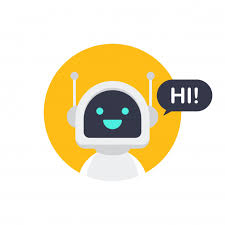

127.0.0.1 - - [18/Mar/2021 20:39:30] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:39:30] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:39:30] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= '' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '197' ;
Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': '', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 197, 'id_elements': 436}
Datos recibidos:
{'id_elemento': '436', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'opc_nextid': 'https://www.youtube.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '436' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '436', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 684, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '436',
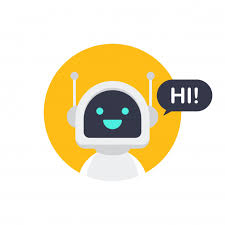
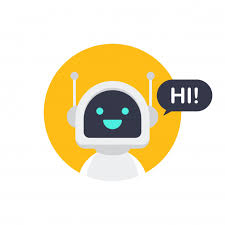

127.0.0.1 - - [18/Mar/2021 20:44:38] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:44:38] "GET /select/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:44:38] "GET /select/elementos HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
Datos enviados:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'api_nlp': 'http://localhost:8282/', 'id_robot': 415, 'id_user': 'charlygoldcruz@gmail.com'}
Datos recibidos:
{'id_robot': '415'}
intenatando consulta...
consult
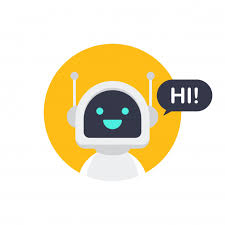

127.0.0.1 - - [18/Mar/2021 20:44:38] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:44:38] "POST /insert/variables HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'prueba_captura', 'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 415, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'prueba_captura' and namestate= 'prueba_inicio' and contenido= 'Hola, soy un chatbot y esto es un mensaje de prueba y adios' and contenttype= 'text' and typingtime= '3' and id_robot= '415' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'next_id': 'prueba_captura', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1246, 'id_robot': 415, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'email', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'String', 'id_robot': 415}
intenatando consulta..

127.0.0.1 - - [18/Mar/2021 20:44:38] "POST /insert/bloqueinput HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:44:38] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:44:38] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinput where next_id= 'pruebaCorreo_01inicial_inicial' and default_id= 'prueba_captura' and namestate= 'prueba_captura' and contenido= 'introduce tu correo' and contenttype= 'text' and typingtime= '3' and validacion= '^[a-z0-9]+[\._]?[a-z0-9]+[@]\w+[.]\w{2,3}$' and id_robot= '415' and id_var= '984' and blocktype= 'input' ;
Datos enviados:
{'namestate': 'prueba_captura', 'contenido': 'introduce tu correo', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'input', 'contenttype': 'text', 'typingtime': '3', 'validacion': '^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$', 'default_id': 'prueba_captura', 'id_var': '984', 'id_block': 152, 'id_robot': 415, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'contenttype': 'text', 'typingtime': 7, 'id_robot': 415, 'blocktype': 'informativo'

127.0.0.1 - - [18/Mar/2021 20:44:38] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:44:39] "POST /insert/bloquequickreply HTTP/1.1" 200 -


Datos recibidos:
{'name_var': 'var_case', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 415}
intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '415' ;
Datos enviados:
{'id_var': 985, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 415, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 415, 'id_var': 985, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '415' and id_var= '985' and bloc

127.0.0.1 - - [18/Mar/2021 20:44:39] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:44:39] "POST /insert/bloqueslide HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '415' ;
Datos enviados:
{'id_var': 986, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 415, 'name_var': 'var_slideMenu'}
Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 986, 'id_robot': 415}
intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '986' and id_robot= '415' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '986', 'id_block': 198, 'id_robot': 415, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://info

127.0.0.1 - - [18/Mar/2021 20:44:39] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:44:39] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:44:39] "POST /insert/botones HTTP/1.1" 200 -


Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 198, 'id_elements': 437}
Datos recibidos:
{'id_elemento': '437', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'opc_nextid': 'https://www.youtube.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '437' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '437', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 686, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '437', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'opc_nextid': 'https://www.reddi

127.0.0.1 - - [18/Mar/2021 20:44:49] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:44:49] "GET /select/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:44:50] "GET /select/elementos HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
Datos enviados:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'api_nlp': 'http://localhost:8282/', 'id_robot': 415, 'id_user': 'charlygoldcruz@gmail.com'}
Datos recibidos:
{'id_robot': '415'}
intenatando consulta...
consult

127.0.0.1 - - [18/Mar/2021 20:44:50] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:44:50] "POST /insert/variables HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'prueba_captura', 'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 415, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'prueba_captura' and namestate= 'prueba_inicio' and contenido= 'Hola, soy un chatbot y esto es un mensaje de prueba y adios' and contenttype= 'text' and typingtime= '3' and id_robot= '415' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'next_id': 'prueba_captura', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1249, 'id_robot': 415, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'email', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'String', 'id_robot': 415}
intenatando consulta..

127.0.0.1 - - [18/Mar/2021 20:44:50] "POST /insert/bloqueinput HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:44:50] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:44:50] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos enviados:
{'namestate': 'prueba_captura', 'contenido': 'introduce tu correo', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'input', 'contenttype': 'text', 'typingtime': '3', 'validacion': '^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$', 'default_id': 'prueba_captura', 'id_var': '987', 'id_block': 153, 'id_robot': 415, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'contenttype': 'text', 'typingtime': 7, 'id_robot': 415, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '415' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pr

127.0.0.1 - - [18/Mar/2021 20:44:50] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:44:50] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:44:50] "POST /insert/variables HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '415' ;
Datos enviados:
{'id_var': 988, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 415, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 415, 'id_var': 988, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '415' and id_var= '988' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu corre

127.0.0.1 - - [18/Mar/2021 20:44:50] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:44:50] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 20:44:50] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '989' and id_robot= '415' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '989', 'id_block': 199, 'id_robot': 415, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 199}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '199' ;
Datos enviados:
{'blocktype': 'slide', 'tit

127.0.0.1 - - [18/Mar/2021 20:44:51] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from botones where id_elemento= '438' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '438', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 689, 'opc_nextid': 'https://www.reddit.com/'}


127.0.0.1 - - [18/Mar/2021 21:07:15] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:07:15] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:07:15] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...


127.0.0.1 - - [18/Mar/2021 21:07:15] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:07:15] "POST /insert/bloqueinput HTTP/1.1" 200 -


Datos recibidos:
{'name_var': 'email', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'String', 'id_robot': 416}
intenatando consulta...
consulta: select * from variables where name_var= 'email' and opc_type= 'Variable' and var= '0' and opc_data= 'String' and id_robot= '416' ;
Datos enviados:
{'id_var': 990, 'opc_type': 'Variable', 'opc_data': 'String', 'var': '0', 'id_robot': 416, 'name_var': 'email'}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'default_id': 'prueba_captura', 'namestate': 'prueba_captura', 'contenido': 'introduce tu correo', 'contenttype': 'text', 'typingtime': 3, 'validacion': '^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$', 'id_robot': 416, 'id_var': 990, 'blocktype': 'input'}
intenatando consulta...
consulta: select * from bloqueinput where next_id= 'pruebaCorreo_01inicial_inicial' and default_id= 'prueba_captura' and namestate= 'prueba_captura' and contenido= 'introduce tu correo' and contenttype= 'text' and typingtime= '3' and validacion= '^[a-z

127.0.0.1 - - [18/Mar/2021 21:07:15] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:07:15] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:07:15] "POST /insert/variables HTTP/1.1" 200 -


Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1253, 'id_robot': 416, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 416, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'Salida' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and contenttype= 'text' and typingtime= '3' and id_robot= '416' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'next_id': 'Salida', 'blocktype': 'informativo', 'contenttype': 'text',

127.0.0.1 - - [18/Mar/2021 21:07:15] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:07:16] "POST /insert/variables HTTP/1.1" 200 -


Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 416, 'id_var': 991, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '416' and id_var= '991' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '991', 'id_block': 438, 'id_robot': 416, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_slide

127.0.0.1 - - [18/Mar/2021 21:07:16] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:07:16] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:07:16] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '992' and id_robot= '416' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '992', 'id_block': 200, 'id_robot': 416, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 200}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '200' ;
Datos enviados:
{'blocktype': 'slide', 'tit

127.0.0.1 - - [18/Mar/2021 21:07:16] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from botones where id_elemento= '439' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '439', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 691, 'opc_nextid': 'https://www.reddit.com/'}


127.0.0.1 - - [18/Mar/2021 21:07:59] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:07:59] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:07:59] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select 

127.0.0.1 - - [18/Mar/2021 21:07:59] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:07:59] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'contenttype': 'text', 'typingtime': 7, 'id_robot': 417, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '417' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1256, 'id_robot': 417, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 417, 'blockty

127.0.0.1 - - [18/Mar/2021 21:07:59] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:07:59] "POST /insert/bloquequickreply HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '417' ;
Datos enviados:
{'id_var': 993, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 417, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 417, 'id_var': 993, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '417' and id_var= '993' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu corre

127.0.0.1 - - [18/Mar/2021 21:08:00] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:08:00] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:08:00] "POST /insert/elementos HTTP/1.1" 200 -


Datos enviados:
{'id_var': 994, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 417, 'name_var': 'var_slideMenu'}
Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 994, 'id_robot': 417}
intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '994' and id_robot= '417' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '994', 'id_block': 201, 'id_robot': 417, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_bl

127.0.0.1 - - [18/Mar/2021 21:08:00] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:08:00] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from botones where id_elemento= '440' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '440', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 692, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '440', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'opc_nextid': 'https://www.reddit.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '440' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '440', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 693, 'opc_nextid': 'https://www.redd

127.0.0.1 - - [18/Mar/2021 21:15:39] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:15:39] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:15:39] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...


127.0.0.1 - - [18/Mar/2021 21:15:39] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:15:39] "POST /insert/bloqueinput HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:15:40] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'email' and opc_type= 'Variable' and var= '0' and opc_data= 'String' and id_robot= '418' ;
Datos enviados:
{'id_var': 995, 'opc_type': 'Variable', 'opc_data': 'String', 'var': '0', 'id_robot': 418, 'name_var': 'email'}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'default_id': 'prueba_captura', 'namestate': 'prueba_captura', 'contenido': 'introduce tu correo', 'contenttype': 'text', 'typingtime': 3, 'validacion': '^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$', 'id_robot': 418, 'id_var': 995, 'blocktype': 'input'}
intenatando consulta...
consulta: select * from bloqueinput where next_id= 'pruebaCorreo_01inicial_inicial' and default_id= 'prueba_captura' and namestate= 'prueba_captura' and contenido= 'introduce tu correo' and contenttype= 'text' and typingtime= '3' and validacion= '^[a-z0-9]+[\._]?[a-z0-9]+[@]\w+[.]\w{2,3}$' and id_robot= '418' and id_var= '995' and blocktype= 'input' ;
Datos envi

127.0.0.1 - - [18/Mar/2021 21:15:40] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:15:40] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:15:40] "POST /insert/bloquequickreply HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'Salida' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and contenttype= 'text' and typingtime= '3' and id_robot= '418' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'next_id': 'Salida', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1260, 'id_robot': 418, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_case', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 418}
intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '418' ;
Datos enviados:
{'id_var': 996, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 418, 'name_

127.0.0.1 - - [18/Mar/2021 21:15:40] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:15:40] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:15:40] "POST /insert/elementos HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '418' ;
Datos enviados:
{'id_var': 997, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 418, 'name_var': 'var_slideMenu'}
Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 997, 'id_robot': 418}
intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '997' and id_robot= '418' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '997', 'id_block': 202, 'id_robot': 418, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://info

127.0.0.1 - - [18/Mar/2021 21:15:40] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:15:40] "POST /insert/botones HTTP/1.1" 200 -


Datos recibidos:
{'id_elemento': '441', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'opc_nextid': 'https://www.youtube.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '441' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '441', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 694, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '441', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'opc_nextid': 'https://www.reddit.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '441' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Dato

127.0.0.1 - - [18/Mar/2021 21:23:30] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:23:30] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:23:30] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...


127.0.0.1 - - [18/Mar/2021 21:23:30] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:23:30] "POST /insert/bloqueinput HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:23:30] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'email' and opc_type= 'Variable' and var= '0' and opc_data= 'String' and id_robot= '419' ;
Datos enviados:
{'id_var': 998, 'opc_type': 'Variable', 'opc_data': 'String', 'var': '0', 'id_robot': 419, 'name_var': 'email'}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'default_id': 'prueba_captura', 'namestate': 'prueba_captura', 'contenido': 'introduce tu correo', 'contenttype': 'text', 'typingtime': 3, 'validacion': '^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$', 'id_robot': 419, 'id_var': 998, 'blocktype': 'input'}
intenatando consulta...
consulta: select * from bloqueinput where next_id= 'pruebaCorreo_01inicial_inicial' and default_id= 'prueba_captura' and namestate= 'prueba_captura' and contenido= 'introduce tu correo' and contenttype= 'text' and typingtime= '3' and validacion= '^[a-z0-9]+[\._]?[a-z0-9]+[@]\w+[.]\w{2,3}$' and id_robot= '419' and id_var= '998' and blocktype= 'input' ;
Datos envi

127.0.0.1 - - [18/Mar/2021 21:23:30] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:23:30] "POST /insert/variables HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 419, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'Salida' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and contenttype= 'text' and typingtime= '3' and id_robot= '419' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'next_id': 'Salida', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1263, 'id_robot': 419, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_case', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 419}
intenatando consulta...
consulta: select * from variables wher

127.0.0.1 - - [18/Mar/2021 21:23:31] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:23:31] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:23:31] "POST /insert/bloqueslide HTTP/1.1" 200 -


Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '999', 'id_block': 441, 'id_robot': 419, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_slideMenu', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 419}
intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '419' ;
Datos enviados:
{'id_var': 1000, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 419, 'name_var': 'var_slideMenu'}
Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 1000, 'id_robot': 419}
intenatando consulta...
consulta: select * from bloqueslide 

127.0.0.1 - - [18/Mar/2021 21:23:31] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:23:31] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:23:31] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '203' ;
Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 203, 'id_elements': 442}
Datos recibidos:
{'id_elemento': '442', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'opc_nextid': 'https://www.youtube.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '442' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '442', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'co

127.0.0.1 - - [18/Mar/2021 21:26:17] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:26:17] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:26:17] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select 

127.0.0.1 - - [18/Mar/2021 21:26:17] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:26:18] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'contenttype': 'text', 'typingtime': 7, 'id_robot': 420, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '420' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1265, 'id_robot': 420, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 420, 'blockty

127.0.0.1 - - [18/Mar/2021 21:26:18] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:26:18] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:26:18] "POST /insert/variables HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '420' ;
Datos enviados:
{'id_var': 1001, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 420, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 420, 'id_var': 1001, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '420' and id_var= '1001' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu co

127.0.0.1 - - [18/Mar/2021 21:26:18] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:26:18] "POST /insert/elementos HTTP/1.1" 200 -


Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 1002, 'id_robot': 420}
intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '1002' and id_robot= '420' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1002', 'id_block': 204, 'id_robot': 420, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 204}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://st2.depositph

127.0.0.1 - - [18/Mar/2021 21:26:18] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:26:18] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from botones where id_elemento= '443' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '443', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 698, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '443', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'opc_nextid': 'https://www.reddit.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '443' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '443', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 699, 'opc_nextid': 'https://www.redd

127.0.0.1 - - [18/Mar/2021 21:34:43] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:34:43] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:34:43] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select 

127.0.0.1 - - [18/Mar/2021 21:34:43] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:34:43] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'contenttype': 'text', 'typingtime': 7, 'id_robot': 421, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '421' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1268, 'id_robot': 421, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 421, 'blockty

127.0.0.1 - - [18/Mar/2021 21:34:43] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:34:43] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:34:44] "POST /insert/variables HTTP/1.1" 200 -


Datos enviados:
{'id_var': 1003, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 421, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 421, 'id_var': 1003, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '421' and id_var= '1003' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1003', 'id_blo

127.0.0.1 - - [18/Mar/2021 21:34:44] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:34:44] "POST /insert/elementos HTTP/1.1" 200 -


Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 1004, 'id_robot': 421}
intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '1004' and id_robot= '421' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1004', 'id_block': 205, 'id_robot': 421, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 205}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://st2.depositph

127.0.0.1 - - [18/Mar/2021 21:34:44] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:34:44] "POST /insert/botones HTTP/1.1" 200 -


Datos enviados:
{'id_elemento': '444', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 700, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '444', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'opc_nextid': 'https://www.reddit.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '444' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '444', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 701, 'opc_nextid': 'https://www.reddit.com/'}


127.0.0.1 - - [18/Mar/2021 21:34:51] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:34:51] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:34:51] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...


127.0.0.1 - - [18/Mar/2021 21:34:52] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:34:52] "POST /insert/bloqueinput HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:34:52] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'email' and opc_type= 'Variable' and var= '0' and opc_data= 'String' and id_robot= '422' ;
Datos enviados:
{'id_var': 1005, 'opc_type': 'Variable', 'opc_data': 'String', 'var': '0', 'id_robot': 422, 'name_var': 'email'}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'default_id': 'prueba_captura', 'namestate': 'prueba_captura', 'contenido': 'introduce tu correo', 'contenttype': 'text', 'typingtime': 3, 'validacion': '^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$', 'id_robot': 422, 'id_var': 1005, 'blocktype': 'input'}
intenatando consulta...
consulta: select * from bloqueinput where next_id= 'pruebaCorreo_01inicial_inicial' and default_id= 'prueba_captura' and namestate= 'prueba_captura' and contenido= 'introduce tu correo' and contenttype= 'text' and typingtime= '3' and validacion= '^[a-z0-9]+[\._]?[a-z0-9]+[@]\w+[.]\w{2,3}$' and id_robot= '422' and id_var= '1005' and blocktype= 'input' ;
Datos e

127.0.0.1 - - [18/Mar/2021 21:34:52] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:34:52] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:34:52] "POST /insert/bloquequickreply HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'Salida' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and contenttype= 'text' and typingtime= '3' and id_robot= '422' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'next_id': 'Salida', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1272, 'id_robot': 422, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_case', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 422}
intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '422' ;
Datos enviados:
{'id_var': 1006, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 422, 'name

127.0.0.1 - - [18/Mar/2021 21:34:52] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:34:52] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:34:52] "POST /insert/elementos HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '422' ;
Datos enviados:
{'id_var': 1007, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 422, 'name_var': 'var_slideMenu'}
Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 1007, 'id_robot': 422}
intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '1007' and id_robot= '422' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1007', 'id_block': 206, 'id_robot': 422, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://

127.0.0.1 - - [18/Mar/2021 21:34:52] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 21:34:52] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from botones where id_elemento= '445' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '445', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 702, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '445', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'opc_nextid': 'https://www.reddit.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '445' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '445', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 703, 'opc_nextid': 'https://www.redd

127.0.0.1 - - [18/Mar/2021 22:49:56] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:49:56] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:49:57] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select 

127.0.0.1 - - [18/Mar/2021 22:49:57] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:49:57] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'contenttype': 'text', 'typingtime': 7, 'id_robot': 423, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '423' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1274, 'id_robot': 423, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 423, 'blockty

127.0.0.1 - - [18/Mar/2021 22:49:57] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:49:57] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:49:57] "POST /insert/variables HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '423' ;
Datos enviados:
{'id_var': 1008, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 423, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 423, 'id_var': 1008, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '423' and id_var= '1008' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu co

127.0.0.1 - - [18/Mar/2021 22:49:57] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:49:57] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:49:57] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '1009' and id_robot= '423' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1009', 'id_block': 207, 'id_robot': 423, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 207}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg' and subtitle= 'Esta es una prueba de carrusel.' and bloc

127.0.0.1 - - [18/Mar/2021 22:49:57] "POST /insert/botones HTTP/1.1" 200 -


Datos recibidos:
{'id_elemento': '446', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'opc_nextid': 'https://www.reddit.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '446' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '446', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 705, 'opc_nextid': 'https://www.reddit.com/'}


127.0.0.1 - - [18/Mar/2021 22:50:04] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:50:04] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:50:04] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...


127.0.0.1 - - [18/Mar/2021 22:50:04] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:50:04] "POST /insert/bloqueinput HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:50:04] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'email' and opc_type= 'Variable' and var= '0' and opc_data= 'String' and id_robot= '424' ;
Datos enviados:
{'id_var': 1010, 'opc_type': 'Variable', 'opc_data': 'String', 'var': '0', 'id_robot': 424, 'name_var': 'email'}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'default_id': 'prueba_captura', 'namestate': 'prueba_captura', 'contenido': 'introduce tu correo', 'contenttype': 'text', 'typingtime': 3, 'validacion': '^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$', 'id_robot': 424, 'id_var': 1010, 'blocktype': 'input'}
intenatando consulta...
consulta: select * from bloqueinput where next_id= 'pruebaCorreo_01inicial_inicial' and default_id= 'prueba_captura' and namestate= 'prueba_captura' and contenido= 'introduce tu correo' and contenttype= 'text' and typingtime= '3' and validacion= '^[a-z0-9]+[\._]?[a-z0-9]+[@]\w+[.]\w{2,3}$' and id_robot= '424' and id_var= '1010' and blocktype= 'input' ;
Datos e

127.0.0.1 - - [18/Mar/2021 22:50:04] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:50:04] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:50:04] "POST /insert/bloquequickreply HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'Salida' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and contenttype= 'text' and typingtime= '3' and id_robot= '424' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'next_id': 'Salida', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1278, 'id_robot': 424, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_case', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 424}
intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '424' ;
Datos enviados:
{'id_var': 1011, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 424, 'name

127.0.0.1 - - [18/Mar/2021 22:50:04] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:50:05] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:50:05] "POST /insert/elementos HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '424' ;
Datos enviados:
{'id_var': 1012, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 424, 'name_var': 'var_slideMenu'}
Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 1012, 'id_robot': 424}
intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '1012' and id_robot= '424' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1012', 'id_block': 208, 'id_robot': 424, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://

127.0.0.1 - - [18/Mar/2021 22:50:05] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:50:05] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from botones where id_elemento= '447' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '447', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 706, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '447', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'opc_nextid': 'https://www.reddit.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '447' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '447', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 707, 'opc_nextid': 'https://www.redd

127.0.0.1 - - [18/Mar/2021 22:56:17] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:56:17] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:56:17] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select 

127.0.0.1 - - [18/Mar/2021 22:56:17] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:56:17] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '425' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1280, 'id_robot': 425, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 425, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'Salida' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and 

127.0.0.1 - - [18/Mar/2021 22:56:18] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:56:18] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:56:18] "POST /insert/variables HTTP/1.1" 200 -


Datos enviados:
{'id_var': 1013, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 425, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 425, 'id_var': 1013, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '425' and id_var= '1013' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1013', 'id_blo

127.0.0.1 - - [18/Mar/2021 22:56:18] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:56:18] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:56:18] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '1014' and id_robot= '425' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1014', 'id_block': 209, 'id_robot': 425, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 209}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg' and subtitle= 'Esta es una prueba de carrusel.' and bloc

127.0.0.1 - - [18/Mar/2021 22:56:18] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from botones where id_elemento= '448' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '448', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 709, 'opc_nextid': 'https://www.reddit.com/'}


127.0.0.1 - - [18/Mar/2021 22:57:35] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:57:35] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:57:35] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...


127.0.0.1 - - [18/Mar/2021 22:57:35] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:57:35] "POST /insert/bloqueinput HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:57:35] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'email' and opc_type= 'Variable' and var= '0' and opc_data= 'String' and id_robot= '426' ;
Datos enviados:
{'id_var': 1015, 'opc_type': 'Variable', 'opc_data': 'String', 'var': '0', 'id_robot': 426, 'name_var': 'email'}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'default_id': 'prueba_captura', 'namestate': 'prueba_captura', 'contenido': 'introduce tu correo', 'contenttype': 'text', 'typingtime': 3, 'validacion': '^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$', 'id_robot': 426, 'id_var': 1015, 'blocktype': 'input'}
intenatando consulta...
consulta: select * from bloqueinput where next_id= 'pruebaCorreo_01inicial_inicial' and default_id= 'prueba_captura' and namestate= 'prueba_captura' and contenido= 'introduce tu correo' and contenttype= 'text' and typingtime= '3' and validacion= '^[a-z0-9]+[\._]?[a-z0-9]+[@]\w+[.]\w{2,3}$' and id_robot= '426' and id_var= '1015' and blocktype= 'input' ;
Datos e

127.0.0.1 - - [18/Mar/2021 22:57:35] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:57:35] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:57:35] "POST /insert/bloquequickreply HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'Salida' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and contenttype= 'text' and typingtime= '3' and id_robot= '426' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'next_id': 'Salida', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1284, 'id_robot': 426, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_case', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 426}
intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '426' ;
Datos enviados:
{'id_var': 1016, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 426, 'name

127.0.0.1 - - [18/Mar/2021 22:57:35] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:57:35] "POST /insert/bloqueslide HTTP/1.1" 200 -


Datos recibidos:
{'name_var': 'var_slideMenu', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 426}
intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '426' ;
Datos enviados:
{'id_var': 1017, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 426, 'name_var': 'var_slideMenu'}
Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 1017, 'id_robot': 426}
intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '1017' and id_robot= '426' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1017', 'id_block': 210, 'id_robot': 426, 'opc_nextid': None, 'pos_y': No

127.0.0.1 - - [18/Mar/2021 22:57:35] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:57:36] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 22:57:36] "POST /insert/botones HTTP/1.1" 200 -


Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 210, 'id_elements': 449}
Datos recibidos:
{'id_elemento': '449', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'opc_nextid': 'https://www.youtube.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '449' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '449', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 710, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '449', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'opc_nextid': 'https://www.reddi

127.0.0.1 - - [18/Mar/2021 23:09:19] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:09:19] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:09:19] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...


127.0.0.1 - - [18/Mar/2021 23:09:19] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:09:19] "POST /insert/bloqueinput HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:09:20] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'email' and opc_type= 'Variable' and var= '0' and opc_data= 'String' and id_robot= '427' ;
Datos enviados:
{'id_var': 1018, 'opc_type': 'Variable', 'opc_data': 'String', 'var': '0', 'id_robot': 427, 'name_var': 'email'}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'default_id': 'prueba_captura', 'namestate': 'prueba_captura', 'contenido': 'introduce tu correo', 'contenttype': 'text', 'typingtime': 3, 'validacion': '^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$', 'id_robot': 427, 'id_var': 1018, 'blocktype': 'input'}
intenatando consulta...
consulta: select * from bloqueinput where next_id= 'pruebaCorreo_01inicial_inicial' and default_id= 'prueba_captura' and namestate= 'prueba_captura' and contenido= 'introduce tu correo' and contenttype= 'text' and typingtime= '3' and validacion= '^[a-z0-9]+[\._]?[a-z0-9]+[@]\w+[.]\w{2,3}$' and id_robot= '427' and id_var= '1018' and blocktype= 'input' ;
Datos e

127.0.0.1 - - [18/Mar/2021 23:09:20] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:09:20] "POST /insert/variables HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 427, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'Salida' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and contenttype= 'text' and typingtime= '3' and id_robot= '427' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'next_id': 'Salida', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1287, 'id_robot': 427, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_case', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 427}
intenatando consulta...
consulta: select * from variables wher

127.0.0.1 - - [18/Mar/2021 23:09:20] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:09:20] "POST /insert/variables HTTP/1.1" 200 -


Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1019', 'id_block': 449, 'id_robot': 427, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_slideMenu', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 427}
intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '427' ;
Datos enviados:
{'id_var': 1020, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 427, 'name_var': 'var_slideMenu'}
Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 1020, 'id_robot': 427}


127.0.0.1 - - [18/Mar/2021 23:09:20] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:09:20] "POST /insert/elementos HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '1020' and id_robot= '427' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1020', 'id_block': 211, 'id_robot': 427, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 211}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '211' ;
Datos enviados:
{'blocktype': 'slide', 't

127.0.0.1 - - [18/Mar/2021 23:09:20] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:09:20] "POST /insert/botones HTTP/1.1" 200 -


Datos enviados:
{'id_elemento': '450', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 712, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '450', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'opc_nextid': 'https://www.reddit.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '450' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '450', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 713, 'opc_nextid': 'https://www.reddit.com/'}


127.0.0.1 - - [18/Mar/2021 23:09:24] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:09:24] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:09:24] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select 

127.0.0.1 - - [18/Mar/2021 23:09:24] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:09:24] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:09:24] "POST /insert/variables HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '428' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1289, 'id_robot': 428, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 428, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'Salida' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and 

127.0.0.1 - - [18/Mar/2021 23:09:25] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:09:25] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:09:25] "POST /insert/bloqueslide HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '428' and id_var= '1021' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1021', 'id_block': 450, 'id_robot': 428, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_slideMenu', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 428}
intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '428' ;
Datos env

127.0.0.1 - - [18/Mar/2021 23:09:25] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:09:25] "POST /insert/botones HTTP/1.1" 200 -


Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 212}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '212' ;
Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 212, 'id_elements': 451}
Datos recibidos:
{'id_elemento': '451', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'opc_nextid': 'https://www

127.0.0.1 - - [18/Mar/2021 23:09:25] "POST /insert/botones HTTP/1.1" 200 -


Datos enviados:
{'id_elemento': '451', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 715, 'opc_nextid': 'https://www.reddit.com/'}


127.0.0.1 - - [18/Mar/2021 23:18:29] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:18:29] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:18:29] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select 

127.0.0.1 - - [18/Mar/2021 23:18:29] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:18:29] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'contenttype': 'text', 'typingtime': 7, 'id_robot': 429, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '429' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1292, 'id_robot': 429, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 429, 'blockty

127.0.0.1 - - [18/Mar/2021 23:18:29] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:18:29] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:18:29] "POST /insert/variables HTTP/1.1" 200 -


Datos enviados:
{'id_var': 1023, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 429, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 429, 'id_var': 1023, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '429' and id_var= '1023' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1023', 'id_blo

127.0.0.1 - - [18/Mar/2021 23:18:29] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:18:29] "POST /insert/elementos HTTP/1.1" 200 -


Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 1024, 'id_robot': 429}
intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '1024' and id_robot= '429' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1024', 'id_block': 213, 'id_robot': 429, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 213}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://st2.depositph

127.0.0.1 - - [18/Mar/2021 23:18:29] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:18:30] "POST /insert/botones HTTP/1.1" 200 -


Datos enviados:
{'id_elemento': '452', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 716, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '452', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'opc_nextid': 'https://www.reddit.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '452' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '452', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 717, 'opc_nextid': 'https://www.reddit.com/'}


127.0.0.1 - - [18/Mar/2021 23:18:42] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:18:42] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:18:42] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...


127.0.0.1 - - [18/Mar/2021 23:18:42] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:18:42] "POST /insert/bloqueinput HTTP/1.1" 200 -


Datos recibidos:
{'name_var': 'email', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'String', 'id_robot': 430}
intenatando consulta...
consulta: select * from variables where name_var= 'email' and opc_type= 'Variable' and var= '0' and opc_data= 'String' and id_robot= '430' ;
Datos enviados:
{'id_var': 1025, 'opc_type': 'Variable', 'opc_data': 'String', 'var': '0', 'id_robot': 430, 'name_var': 'email'}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'default_id': 'prueba_captura', 'namestate': 'prueba_captura', 'contenido': 'introduce tu correo', 'contenttype': 'text', 'typingtime': 3, 'validacion': '^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$', 'id_robot': 430, 'id_var': 1025, 'blocktype': 'input'}
intenatando consulta...
consulta: select * from bloqueinput where next_id= 'pruebaCorreo_01inicial_inicial' and default_id= 'prueba_captura' and namestate= 'prueba_captura' and contenido= 'introduce tu correo' and contenttype= 'text' and typingtime= '3' and validacion= '^[a

127.0.0.1 - - [18/Mar/2021 23:18:42] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:18:42] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:18:42] "POST /insert/variables HTTP/1.1" 200 -


Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1295, 'id_robot': 430, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 430, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'Salida' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and contenttype= 'text' and typingtime= '3' and id_robot= '430' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'next_id': 'Salida', 'blocktype': 'informativo', 'contenttype': 'text',

127.0.0.1 - - [18/Mar/2021 23:18:42] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:18:43] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:18:43] "POST /insert/bloqueslide HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '430' and id_var= '1026' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1026', 'id_block': 452, 'id_robot': 430, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_slideMenu', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 430}
intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '430' ;
Datos env

127.0.0.1 - - [18/Mar/2021 23:18:43] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:18:43] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:18:43] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '214' ;
Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 214, 'id_elements': 453}
Datos recibidos:
{'id_elemento': '453', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'opc_nextid': 'https://www.youtube.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '453' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '453', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'co

127.0.0.1 - - [18/Mar/2021 23:30:44] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:30:44] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:30:44] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...


127.0.0.1 - - [18/Mar/2021 23:30:44] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:30:44] "POST /insert/bloqueinput HTTP/1.1" 200 -


Datos recibidos:
{'name_var': 'email', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'String', 'id_robot': 431}
intenatando consulta...
consulta: select * from variables where name_var= 'email' and opc_type= 'Variable' and var= '0' and opc_data= 'String' and id_robot= '431' ;
Datos enviados:
{'id_var': 1028, 'opc_type': 'Variable', 'opc_data': 'String', 'var': '0', 'id_robot': 431, 'name_var': 'email'}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'default_id': 'prueba_captura', 'namestate': 'prueba_captura', 'contenido': 'introduce tu correo', 'contenttype': 'text', 'typingtime': 3, 'validacion': '^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$', 'id_robot': 431, 'id_var': 1028, 'blocktype': 'input'}
intenatando consulta...
consulta: select * from bloqueinput where next_id= 'pruebaCorreo_01inicial_inicial' and default_id= 'prueba_captura' and namestate= 'prueba_captura' and contenido= 'introduce tu correo' and contenttype= 'text' and typingtime= '3' and validacion= '^[a

127.0.0.1 - - [18/Mar/2021 23:30:44] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:30:44] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:30:45] "POST /insert/variables HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '431' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1298, 'id_robot': 431, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 431, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'Salida' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and 

127.0.0.1 - - [18/Mar/2021 23:30:45] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:30:45] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:30:45] "POST /insert/bloqueslide HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '431' and id_var= '1029' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1029', 'id_block': 453, 'id_robot': 431, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_slideMenu', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 431}
intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '431' ;
Datos env

127.0.0.1 - - [18/Mar/2021 23:30:45] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:30:45] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:30:45] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '215' ;
Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 215, 'id_elements': 454}
Datos recibidos:
{'id_elemento': '454', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'opc_nextid': 'https://www.youtube.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '454' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '454', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'co

127.0.0.1 - - [18/Mar/2021 23:33:04] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:33:04] "POST /insert/robots HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...


127.0.0.1 - - [18/Mar/2021 23:33:05] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:33:05] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:33:05] "POST /insert/bloqueinput HTTP/1.1" 200 -


Datos enviados:
{'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'next_id': 'prueba_captura', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1300, 'id_robot': 432, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'email', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'String', 'id_robot': 432}
intenatando consulta...
consulta: select * from variables where name_var= 'email' and opc_type= 'Variable' and var= '0' and opc_data= 'String' and id_robot= '432' ;
Datos enviados:
{'id_var': 1031, 'opc_type': 'Variable', 'opc_data': 'String', 'var': '0', 'id_robot': 432, 'name_var': 'email'}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'default_id': 'prueba_captura', 'namestate': 'prueba_captura', 'contenido': 'introduce tu correo', 'contenttype': 'text', 'typingtime': 3, 'validacion': '^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$', 'i

127.0.0.1 - - [18/Mar/2021 23:33:05] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:33:05] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:33:05] "POST /insert/variables HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '432' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1301, 'id_robot': 432, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 432, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'Salida' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and 

127.0.0.1 - - [18/Mar/2021 23:33:05] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:33:05] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:33:05] "POST /insert/bloqueslide HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '432' and id_var= '1032' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1032', 'id_block': 454, 'id_robot': 432, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_slideMenu', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 432}
intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '432' ;
Datos env

127.0.0.1 - - [18/Mar/2021 23:33:05] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:33:05] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:33:05] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '216' ;
Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 216, 'id_elements': 455}
Datos recibidos:
{'id_elemento': '455', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'opc_nextid': 'https://www.youtube.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '455' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '455', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'co

127.0.0.1 - - [18/Mar/2021 23:37:53] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:37:53] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:37:53] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...


127.0.0.1 - - [18/Mar/2021 23:37:53] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:37:53] "POST /insert/bloqueinput HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:37:53] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'email' and opc_type= 'Variable' and var= '0' and opc_data= 'String' and id_robot= '433' ;
Datos enviados:
{'id_var': 1034, 'opc_type': 'Variable', 'opc_data': 'String', 'var': '0', 'id_robot': 433, 'name_var': 'email'}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'default_id': 'prueba_captura', 'namestate': 'prueba_captura', 'contenido': 'introduce tu correo', 'contenttype': 'text', 'typingtime': 3, 'validacion': '^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$', 'id_robot': 433, 'id_var': 1034, 'blocktype': 'input'}
intenatando consulta...
consulta: select * from bloqueinput where next_id= 'pruebaCorreo_01inicial_inicial' and default_id= 'prueba_captura' and namestate= 'prueba_captura' and contenido= 'introduce tu correo' and contenttype= 'text' and typingtime= '3' and validacion= '^[a-z0-9]+[\._]?[a-z0-9]+[@]\w+[.]\w{2,3}$' and id_robot= '433' and id_var= '1034' and blocktype= 'input' ;
Datos e

127.0.0.1 - - [18/Mar/2021 23:37:53] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:37:53] "POST /insert/variables HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 433, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'Salida' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and contenttype= 'text' and typingtime= '3' and id_robot= '433' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'next_id': 'Salida', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1305, 'id_robot': 433, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_case', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 433}
intenatando consulta...
consulta: select * from variables wher

127.0.0.1 - - [18/Mar/2021 23:37:53] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:37:54] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:37:54] "POST /insert/bloqueslide HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '433' and id_var= '1035' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1035', 'id_block': 455, 'id_robot': 433, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_slideMenu', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 433}
intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '433' ;
Datos env

127.0.0.1 - - [18/Mar/2021 23:37:54] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:37:54] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:37:54] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '217' ;
Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 217, 'id_elements': 456}
Datos recibidos:
{'id_elemento': '456', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'opc_nextid': 'https://www.youtube.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '456' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '456', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'co

127.0.0.1 - - [18/Mar/2021 23:40:56] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:40:56] "POST /insert/robots HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...


127.0.0.1 - - [18/Mar/2021 23:40:56] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:40:56] "POST /insert/variables HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'prueba_captura' and namestate= 'prueba_inicio' and contenido= 'Hola, soy un chatbot y esto es un mensaje de prueba y adios' and contenttype= 'text' and typingtime= '3' and id_robot= '434' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'next_id': 'prueba_captura', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1306, 'id_robot': 434, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'email', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'String', 'id_robot': 434}
intenatando consulta...
consulta: select * from variables where name_var= 'email' and opc_type= 'Variable' and var= '0' and opc_data= 'String' and id_robot= '434' ;
Datos enviados:
{'id_var': 1037, 'opc_type': 'Variable', 'opc_data': 'String', 'var': '0', 'id_

127.0.0.1 - - [18/Mar/2021 23:40:57] "POST /insert/bloqueinput HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:40:57] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:40:57] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinput where next_id= 'pruebaCorreo_01inicial_inicial' and default_id= 'prueba_captura' and namestate= 'prueba_captura' and contenido= 'introduce tu correo' and contenttype= 'text' and typingtime= '3' and validacion= '^[a-z0-9]+[\._]?[a-z0-9]+[@]\w+[.]\w{2,3}$' and id_robot= '434' and id_var= '1037' and blocktype= 'input' ;
Datos enviados:
{'namestate': 'prueba_captura', 'contenido': 'introduce tu correo', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'input', 'contenttype': 'text', 'typingtime': '3', 'validacion': '^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$', 'default_id': 'prueba_captura', 'id_var': '1037', 'id_block': 165, 'id_robot': 434, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'contenttype': 'text', 'typingtime': 7, 'id_robot': 434, 'blocktype': 'informativ

127.0.0.1 - - [18/Mar/2021 23:40:57] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:40:57] "POST /insert/bloquequickreply HTTP/1.1" 200 -


Datos recibidos:
{'name_var': 'var_case', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 434}
intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '434' ;
Datos enviados:
{'id_var': 1038, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 434, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 434, 'id_var': 1038, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '434' and id_var= '1038' and b

127.0.0.1 - - [18/Mar/2021 23:40:57] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:40:57] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:40:57] "POST /insert/elementos HTTP/1.1" 200 -


Datos enviados:
{'id_var': 1039, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 434, 'name_var': 'var_slideMenu'}
Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 1039, 'id_robot': 434}
intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '1039' and id_robot= '434' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1039', 'id_block': 218, 'id_robot': 434, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 218}
intenatando consulta...


127.0.0.1 - - [18/Mar/2021 23:40:57] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:40:57] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from botones where id_elemento= '457' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '457', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 726, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '457', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'opc_nextid': 'https://www.reddit.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '457' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '457', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 727, 'opc_nextid': 'https://www.redd

127.0.0.1 - - [18/Mar/2021 23:45:39] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:45:39] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:45:39] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...


127.0.0.1 - - [18/Mar/2021 23:45:39] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:45:39] "POST /insert/bloqueinput HTTP/1.1" 200 -


Datos recibidos:
{'name_var': 'email', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'String', 'id_robot': 435}
intenatando consulta...
consulta: select * from variables where name_var= 'email' and opc_type= 'Variable' and var= '0' and opc_data= 'String' and id_robot= '435' ;
Datos enviados:
{'id_var': 1040, 'opc_type': 'Variable', 'opc_data': 'String', 'var': '0', 'id_robot': 435, 'name_var': 'email'}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'default_id': 'prueba_captura', 'namestate': 'prueba_captura', 'contenido': 'introduce tu correo', 'contenttype': 'text', 'typingtime': 3, 'validacion': '^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$', 'id_robot': 435, 'id_var': 1040, 'blocktype': 'input'}
intenatando consulta...
consulta: select * from bloqueinput where next_id= 'pruebaCorreo_01inicial_inicial' and default_id= 'prueba_captura' and namestate= 'prueba_captura' and contenido= 'introduce tu correo' and contenttype= 'text' and typingtime= '3' and validacion= '^[a

127.0.0.1 - - [18/Mar/2021 23:45:39] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:45:40] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:45:40] "POST /insert/variables HTTP/1.1" 200 -


Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1310, 'id_robot': 435, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 435, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'Salida' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and contenttype= 'text' and typingtime= '3' and id_robot= '435' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'next_id': 'Salida', 'blocktype': 'informativo', 'contenttype': 'text',

127.0.0.1 - - [18/Mar/2021 23:45:40] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:45:40] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:45:40] "POST /insert/bloqueslide HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '435' and id_var= '1041' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1041', 'id_block': 457, 'id_robot': 435, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_slideMenu', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 435}
intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '435' ;
Datos env

127.0.0.1 - - [18/Mar/2021 23:45:40] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:45:40] "POST /insert/botones HTTP/1.1" 200 -


Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 219}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '219' ;
Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 219, 'id_elements': 458}
Datos recibidos:
{'id_elemento': '458', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'opc_nextid': 'https://www.youtube.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '458' and titlebutton= 'Bo

127.0.0.1 - - [18/Mar/2021 23:45:40] "POST /insert/botones HTTP/1.1" 200 -


Datos enviados:
{'id_elemento': '458', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 729, 'opc_nextid': 'https://www.reddit.com/'}


127.0.0.1 - - [18/Mar/2021 23:48:46] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:48:46] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:48:46] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select 

127.0.0.1 - - [18/Mar/2021 23:48:46] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:48:46] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:48:46] "POST /insert/variables HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '436' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1313, 'id_robot': 436, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 436, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'Salida' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and 

127.0.0.1 - - [18/Mar/2021 23:48:46] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:48:46] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:48:46] "POST /insert/bloqueslide HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '436' and id_var= '1043' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1043', 'id_block': 458, 'id_robot': 436, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_slideMenu', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 436}
intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '436' ;
Datos env

127.0.0.1 - - [18/Mar/2021 23:48:46] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:48:46] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:48:47] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '220' ;
Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 220, 'id_elements': 459}
Datos recibidos:
{'id_elemento': '459', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'opc_nextid': 'https://www.youtube.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '459' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:

127.0.0.1 - - [18/Mar/2021 23:52:14] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:52:14] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:52:15] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...


127.0.0.1 - - [18/Mar/2021 23:52:15] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:52:15] "POST /insert/bloqueinput HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:52:15] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'email' and opc_type= 'Variable' and var= '0' and opc_data= 'String' and id_robot= '437' ;
Datos enviados:
{'id_var': 1045, 'opc_type': 'Variable', 'opc_data': 'String', 'var': '0', 'id_robot': 437, 'name_var': 'email'}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'default_id': 'prueba_captura', 'namestate': 'prueba_captura', 'contenido': 'introduce tu correo', 'contenttype': 'text', 'typingtime': 3, 'validacion': '^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$', 'id_robot': 437, 'id_var': 1045, 'blocktype': 'input'}
intenatando consulta...
consulta: select * from bloqueinput where next_id= 'pruebaCorreo_01inicial_inicial' and default_id= 'prueba_captura' and namestate= 'prueba_captura' and contenido= 'introduce tu correo' and contenttype= 'text' and typingtime= '3' and validacion= '^[a-z0-9]+[\._]?[a-z0-9]+[@]\w+[.]\w{2,3}$' and id_robot= '437' and id_var= '1045' and blocktype= 'input' ;
Datos e

127.0.0.1 - - [18/Mar/2021 23:52:15] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:52:15] "POST /insert/variables HTTP/1.1" 200 -


Datos recibidos:
{'next_id': '', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 437, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= '' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and contenttype= 'text' and typingtime= '3' and id_robot= '437' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'next_id': '', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1317, 'id_robot': 437, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_case', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 437}
intenatando consulta...
consulta: select * from variables where name_var= 'var_c

127.0.0.1 - - [18/Mar/2021 23:52:15] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:52:15] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:52:15] "POST /insert/bloqueslide HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '437' and id_var= '1046' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1046', 'id_block': 459, 'id_robot': 437, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_slideMenu', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 437}
intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '437' ;
Datos env

127.0.0.1 - - [18/Mar/2021 23:52:15] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:52:15] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:52:15] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '221' ;
Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 221, 'id_elements': 460}
Datos recibidos:
{'id_elemento': '460', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'opc_nextid': 'https://www.youtube.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '460' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '460', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'co

127.0.0.1 - - [18/Mar/2021 23:54:36] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:54:36] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:54:36] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...


127.0.0.1 - - [18/Mar/2021 23:54:36] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:54:36] "POST /insert/bloqueinput HTTP/1.1" 200 -


Datos recibidos:
{'name_var': 'email', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'String', 'id_robot': 438}
intenatando consulta...
consulta: select * from variables where name_var= 'email' and opc_type= 'Variable' and var= '0' and opc_data= 'String' and id_robot= '438' ;
Datos enviados:
{'id_var': 1048, 'opc_type': 'Variable', 'opc_data': 'String', 'var': '0', 'id_robot': 438, 'name_var': 'email'}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'default_id': 'prueba_captura', 'namestate': 'prueba_captura', 'contenido': 'introduce tu correo', 'contenttype': 'text', 'typingtime': 3, 'validacion': '^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$', 'id_robot': 438, 'id_var': 1048, 'blocktype': 'input'}
intenatando consulta...
consulta: select * from bloqueinput where next_id= 'pruebaCorreo_01inicial_inicial' and default_id= 'prueba_captura' and namestate= 'prueba_captura' and contenido= 'introduce tu correo' and contenttype= 'text' and typingtime= '3' and validacion= '^[a

127.0.0.1 - - [18/Mar/2021 23:54:36] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:54:36] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:54:36] "POST /insert/variables HTTP/1.1" 200 -


Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1319, 'id_robot': 438, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': '', 'namestate': 'Salida', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 438, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= '' and namestate= 'Salida' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and contenttype= 'text' and typingtime= '3' and id_robot= '438' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'Salida', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'next_id': '', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block'

127.0.0.1 - - [18/Mar/2021 23:54:37] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:54:37] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:54:37] "POST /insert/bloqueslide HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'Salir del bot.,Probar carrusel' and next_id= 'Salida,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '438' and id_var= '1049' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'Salir del bot.,Probar carrusel', 'next_id': 'Salida,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1049', 'id_block': 460, 'id_robot': 438, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_slideMenu', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 438}
intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico'

127.0.0.1 - - [18/Mar/2021 23:54:37] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:54:37] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:54:37] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '222' ;
Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 222, 'id_elements': 461}
Datos recibidos:
{'id_elemento': '461', 'titlebutton': 'Youtube', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'opc_nextid': 'https://www.youtube.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '461' and titlebutton= 'Youtube' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '461', 'titlebutton': 'Youtube', 'typebutton': 'web_url', 'co

127.0.0.1 - - [18/Mar/2021 23:56:30] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:56:30] "GET /select/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:56:30] "GET /select/elementos HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
Datos enviados:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'api_nlp': 'http://localhost:8282/', 'id_robot': 438, 'id_user': 'charlygoldcruz@gmail.com'}
Datos recibidos:
{'id_robot': '438'}
intenatando consulta...
consult

127.0.0.1 - - [18/Mar/2021 23:56:31] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:56:31] "POST /insert/variables HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'prueba_captura', 'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 438, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'prueba_captura' and namestate= 'prueba_inicio' and contenido= 'Hola, soy un chatbot y esto es un mensaje de prueba y adios' and contenttype= 'text' and typingtime= '3' and id_robot= '438' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'next_id': 'prueba_captura', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1321, 'id_robot': 438, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'email', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'String', 'id_robot': 438}
intenatando consulta..

127.0.0.1 - - [18/Mar/2021 23:56:31] "POST /insert/bloqueinput HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:56:31] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:56:31] "POST /insert/variables HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinput where next_id= 'pruebaCorreo_01inicial_inicial' and default_id= 'prueba_captura' and namestate= 'prueba_captura' and contenido= 'introduce tu correo' and contenttype= 'text' and typingtime= '3' and validacion= '^[a-z0-9]+[\._]?[a-z0-9]+[@]\w+[.]\w{2,3}$' and id_robot= '438' and id_var= '1051' and blocktype= 'input' ;
Datos enviados:
{'namestate': 'prueba_captura', 'contenido': 'introduce tu correo', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'input', 'contenttype': 'text', 'typingtime': '3', 'validacion': '^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$', 'default_id': 'prueba_captura', 'id_var': '1051', 'id_block': 169, 'id_robot': 438, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'contenttype': 'text', 'typingtime': 7, 'id_robot': 438, 'blocktype': 'informativ

127.0.0.1 - - [18/Mar/2021 23:56:31] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:56:31] "POST /insert/variables HTTP/1.1" 200 -


Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'Salir del bot.,Probar carrusel', 'next_id': 'Salida,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 438, 'id_var': 1052, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'Salir del bot.,Probar carrusel' and next_id= 'Salida,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '438' and id_var= '1052' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'Salir del bot.,Probar carrusel', 'next_id': 'Salida,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1052', 'id_block': 461, 'id_robot': 438, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_acti

127.0.0.1 - - [18/Mar/2021 23:56:31] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:56:31] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:56:31] "POST /insert/botones HTTP/1.1" 200 -


Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1053', 'id_block': 223, 'id_robot': 438, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 223}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '223' ;
Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 223, 'id_elements': 462}
Datos rec

127.0.0.1 - - [18/Mar/2021 23:56:31] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from botones where id_elemento= '462' and titlebutton= 'Reddit' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '462', 'titlebutton': 'Reddit', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 737, 'opc_nextid': 'https://www.reddit.com/'}


127.0.0.1 - - [18/Mar/2021 23:59:43] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:59:43] "GET /select/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:59:43] "GET /select/elementos HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
Datos enviados:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'api_nlp': 'http://localhost:8282/', 'id_robot': 438, 'id_user': 'charlygoldcruz@gmail.com'}
Datos recibidos:
{'id_robot': '438'}
intenatando consulta...
consult

127.0.0.1 - - [18/Mar/2021 23:59:43] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:59:43] "POST /insert/variables HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'prueba_captura', 'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 438, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'prueba_captura' and namestate= 'prueba_inicio' and contenido= 'Hola, soy un chatbot y esto es un mensaje de prueba y adios' and contenttype= 'text' and typingtime= '3' and id_robot= '438' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'next_id': 'prueba_captura', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1323, 'id_robot': 438, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'email', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'String', 'id_robot': 438}
intenatando consulta..

127.0.0.1 - - [18/Mar/2021 23:59:44] "POST /insert/bloqueinput HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:59:44] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:59:44] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos enviados:
{'namestate': 'prueba_captura', 'contenido': 'introduce tu correo', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'input', 'contenttype': 'text', 'typingtime': '3', 'validacion': '^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$', 'default_id': 'prueba_captura', 'id_var': '1054', 'id_block': 170, 'id_robot': 438, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'contenttype': 'text', 'typingtime': 7, 'id_robot': 438, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '438' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'p

127.0.0.1 - - [18/Mar/2021 23:59:44] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:59:44] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:59:44] "POST /insert/variables HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '438' ;
Datos enviados:
{'id_var': 1055, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 438, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'Salir del bot.,Probar carrusel', 'next_id': 'mensaje_salida,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 438, 'id_var': 1055, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'Salir del bot.,Probar carrusel' and next_id= 'mensaje_salida,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '438' and id_var= '1055' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_

127.0.0.1 - - [18/Mar/2021 23:59:44] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:59:44] "POST /insert/elementos HTTP/1.1" 200 -


Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 1056, 'id_robot': 438}
intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '1056' and id_robot= '438' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1056', 'id_block': 224, 'id_robot': 438, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 224}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-te

127.0.0.1 - - [18/Mar/2021 23:59:44] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [18/Mar/2021 23:59:44] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from botones where id_elemento= '463' and titlebutton= 'Youtube' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '463', 'titlebutton': 'Youtube', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 738, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '463', 'titlebutton': 'Reddit', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'opc_nextid': 'https://www.reddit.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '463' and titlebutton= 'Reddit' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '463', 'titlebutton': 'Reddit', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 739, 'opc_nextid': 'https://www.reddit.

127.0.0.1 - - [19/Mar/2021 00:01:29] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [19/Mar/2021 00:01:29] "GET /select/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [19/Mar/2021 00:01:29] "GET /select/elementos HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
Datos enviados:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'api_nlp': 'http://localhost:8282/', 'id_robot': 438, 'id_user': 'charlygoldcruz@gmail.com'}
Datos recibidos:
{'id_robot': '438'}
intenatando consulta...
consult

127.0.0.1 - - [19/Mar/2021 00:01:29] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [19/Mar/2021 00:01:29] "POST /insert/variables HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'prueba_captura', 'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 438, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'prueba_captura' and namestate= 'prueba_inicio' and contenido= 'Hola, soy un chatbot y esto es un mensaje de prueba y adios' and contenttype= 'text' and typingtime= '3' and id_robot= '438' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'next_id': 'prueba_captura', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1326, 'id_robot': 438, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'email', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'String', 'id_robot': 438}
intenatando consulta..

127.0.0.1 - - [19/Mar/2021 00:01:29] "POST /insert/bloqueinput HTTP/1.1" 200 -
127.0.0.1 - - [19/Mar/2021 00:01:29] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [19/Mar/2021 00:01:29] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos enviados:
{'namestate': 'prueba_captura', 'contenido': 'introduce tu correo', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'input', 'contenttype': 'text', 'typingtime': '3', 'validacion': '^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$', 'default_id': 'prueba_captura', 'id_var': '1057', 'id_block': 171, 'id_robot': 438, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'contenttype': 'text', 'typingtime': 7, 'id_robot': 438, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '438' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'p

127.0.0.1 - - [19/Mar/2021 00:01:29] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [19/Mar/2021 00:01:29] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [19/Mar/2021 00:01:29] "POST /insert/bloquequickreply HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinformativo where next_id= '' and namestate= 'Salida' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and contenttype= 'text' and typingtime= '3' and id_robot= '438' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'Salida', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'next_id': '', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1329, 'id_robot': 438, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_case', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 438}
intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '438' ;
Datos enviados:
{'id_var': 1058, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 438, 'name_var': 'var_case'}
D

127.0.0.1 - - [19/Mar/2021 00:01:30] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [19/Mar/2021 00:01:30] "POST /insert/bloqueslide HTTP/1.1" 200 -


Datos recibidos:
{'name_var': 'var_slideMenu', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 438}
intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '438' ;
Datos enviados:
{'id_var': 1059, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 438, 'name_var': 'var_slideMenu'}
Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 1059, 'id_robot': 438}
intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '1059' and id_robot= '438' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '1059', 'id_block': 225, 'id_robot': 438, 'opc_nextid': None, 'pos_y': No

127.0.0.1 - - [19/Mar/2021 00:01:30] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [19/Mar/2021 00:01:30] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [19/Mar/2021 00:01:30] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '225' ;
Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': 'https://infosertecblog.files.wordpress.com/2016/08/bot-de-telegram.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 225, 'id_elements': 464}
Datos recibidos:
{'id_elemento': '464', 'titlebutton': 'Youtube', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'opc_nextid': 'https://www.youtube.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '464' and titlebutton= 'Youtube' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '464', 'titlebutton': 'Youtube', 'typebutton': 'web_url', 'co

In [ ]:
if __name__ == "__main__":    
    app.run(host='localhost',port='8181')